In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from PIL import Image
import requests
import IPython

pd.options.display.max_rows = None
pd.options.display.max_columns = None

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *#avg, count, expr
from pyspark.sql.types import *

In [2]:
# initialize
sc = pyspark.SparkContext()
spark = SparkSession(sc)
spark.sparkContext.appName = 'searchandF'
# show the number of cores
print('%d cores'%spark._jsc.sc().getExecutorMemoryStatus().keySet().size())
spark

1 cores


In [3]:
# data from https://www.kaggle.com/karangadiya/fifa19
# define the schema
schem = StructType([StructField('_c0', IntegerType()),
                    StructField('ID', IntegerType()),
                    StructField('Name', StringType()),
                    StructField('Age', IntegerType()),
                    StructField('Photo', StringType()),
                    StructField('Nationality', StringType()),
                    StructField('Flag', StringType()),
                    StructField('Overall', IntegerType()),
                    StructField('Potential', IntegerType()),
                    StructField('Club', StringType()),
                    StructField('Club Logo', StringType()),
                    StructField('Value', StringType()),
                    StructField('Wage', StringType()),
                    StructField('Special', IntegerType()),
                    StructField('Preferred Foot', StringType()),
                    StructField('International Reputation', IntegerType()),
                    StructField('Weak Foot', IntegerType()),
                    StructField('Skill Moves', IntegerType()),
                    StructField('Work Rate', StringType()),
                    StructField('Body Type', StringType()),
                    StructField('Real Face', StringType()),
                    StructField('Position', StringType()),
                    StructField('Jersey Number', IntegerType()),
                    StructField('Joined', StringType()),
                    StructField('Loaned From', StringType()),
                    StructField('Contract Valid Until', IntegerType()),
                    StructField('Height', StringType()),
                    StructField('Weight', StringType()),
                    StructField('LS', StringType()),
                    StructField('ST', StringType()),
                    StructField('RS', StringType()),
                    StructField('LW', StringType()),
                    StructField('LF', StringType()),
                    StructField('CF', StringType()),
                    StructField('RF', StringType()),
                    StructField('RW', StringType()),
                    StructField('LAM', StringType()),
                    StructField('CAM', StringType()),
                    StructField('RAM', StringType()),
                    StructField('LM', StringType()),
                    StructField('LCM', StringType()),
                    StructField('CM', StringType()),
                    StructField('RCM', StringType()),
                    StructField('RM', StringType()),
                    StructField('LWB', StringType()),
                    StructField('LDM', StringType()),
                    StructField('CDM', StringType()),
                    StructField('RDM', StringType()),
                    StructField('RWB', StringType()),
                    StructField('LB', StringType()),
                    StructField('LCB', StringType()),
                    StructField('CB', StringType()),
                    StructField('RCB', StringType()),
                    StructField('RB', StringType()),
                    StructField('Crossing', IntegerType()),
                    StructField('Finishing', IntegerType()),
                    StructField('HeadingAccuracy', IntegerType()),
                    StructField('ShortPassing', IntegerType()),
                    StructField('Volleys', IntegerType()),
                    StructField('Dribbling', IntegerType()),
                    StructField('Curve', IntegerType()),
                    StructField('FKAccuracy', IntegerType()),
                    StructField('LongPassing', IntegerType()),
                    StructField('BallControl', IntegerType()),
                    StructField('Acceleration', IntegerType()),
                    StructField('SprintSpeed', IntegerType()),
                    StructField('Agility', IntegerType()),
                    StructField('Reactions', IntegerType()),
                    StructField('Balance', IntegerType()),
                    StructField('ShotPower', IntegerType()),
                    StructField('Jumping', IntegerType()),
                    StructField('Stamina', IntegerType()),
                    StructField('Strength', IntegerType()),
                    StructField('LongShots', IntegerType()),
                    StructField('Aggression', IntegerType()),
                    StructField('Interceptions', IntegerType()),
                    StructField('Positioning', IntegerType()),
                    StructField('Vision', IntegerType()),
                    StructField('Penalties', IntegerType()),
                    StructField('Composure', IntegerType()),
                    StructField('Marking', IntegerType()),
                    StructField('StandingTackle', IntegerType()),
                    StructField('SlidingTackle', IntegerType()),
                    StructField('GKDiving', IntegerType()),
                    StructField('GKHandling', IntegerType()),
                    StructField('GKKicking', IntegerType()),
                    StructField('GKPositioning', IntegerType()),
                    StructField('GKReflexes', IntegerType()),
                    StructField('Release Clause', StringType())])

# load data - dropping the first columns
fil = '../data/fifa19.csv'
fifa = spark.read.format('csv').options(header=True).schema(schem).load(fil)
fifa = fifa.select(fifa.columns[1:])

# talk
display(fifa.limit(10).toPandas())

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5,4,4,Medium/ Medium,Messi,Yes,RF,10,"Jul 1, 2004",None,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5,4,5,High/ Low,C. Ronaldo,Yes,ST,7,"Jul 10, 2018",None,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5,5,5,High/ Medium,Neymar,Yes,LW,10,"Aug 3, 2017",None,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4,3,1,Medium/ Medium,Lean,Yes,GK,1,"Jul 1, 2011",None,2020,6'4,168lbs,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4,5,4,High/ High,Normal,Yes,RCM,7,"Aug 30, 2015",None,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93,82,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,61,87,94,79,88,68,58,51,15,13,5,10,13,€196.4M
5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,https://cdn.sofifa.org/teams/2/light/5.png,€93M,€340K,2142,Right,4,4,4,High/ Medium,Normal,Yes,LF,10,"Jul 1, 2012",None,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3,81,84,61,89,80,95,83,79,83,94,94,88,95,90,94,82,56,83,66,80,54,41,87,89,86,91,34,27,22,11,12,6,8,8,€172.1M
6,177003,L. Modrić,32,https://cdn.sofifa.org/players/4/19/177003.png,Croatia,https://cdn.sofifa.org/flags/10.png,91,91,Real Madrid,https://cdn.sofifa.org/teams/2/light/243.png,€67M,€420K,2280,Right,4,4,4,High/ High,Lea

## Explore the data

In [22]:
fifa.select('Nationality', 'Name', 'Age', 'Photo').show(5, False)
fifa.select('Photo')

+-----------+-----------------+---+----------------------------------------------+
|Nationality|Name             |Age|Photo                                         |
+-----------+-----------------+---+----------------------------------------------+
|Argentina  |L. Messi         |31 |https://cdn.sofifa.org/players/4/19/158023.png|
|Portugal   |Cristiano Ronaldo|33 |https://cdn.sofifa.org/players/4/19/20801.png |
|Brazil     |Neymar Jr        |26 |https://cdn.sofifa.org/players/4/19/190871.png|
|Spain      |De Gea           |27 |https://cdn.sofifa.org/players/4/19/193080.png|
|Belgium    |K. De Bruyne     |27 |https://cdn.sofifa.org/players/4/19/192985.png|
+-----------+-----------------+---+----------------------------------------------+
only showing top 5 rows



In [37]:
# image url is no longer valid
pic = fifa.select('Photo').limit(1).toPandas().values[-1][0]
IPython.display.Image(pic, width=500)

HTTPError: HTTP Error 403: Forbidden

In [42]:
# top youngest & oldest
N = 10
ages = fifa.select('Name', 'Nationality', 'Age').orderBy('Age')
print('Top %d Youngest'%N)
display(ages.head(N))
print('Top %d Oldest'%N)
display(ages.tail(N))

Top 10 Youngest


[Row(Name='W. Geubbels', Nationality='France', Age=16),
 Row(Name='J. Italiano', Nationality='Australia', Age=16),
 Row(Name='A. Taoui', Nationality='France', Age=16),
 Row(Name='Pelayo Morilla', Nationality='Spain', Age=16),
 Row(Name='Guerrero', Nationality='Spain', Age=16),
 Row(Name='H. Massengo', Nationality='France', Age=16),
 Row(Name='Y. Verschaeren', Nationality='Belgium', Age=16),
 Row(Name='Y. Roemer', Nationality='Netherlands', Age=16),
 Row(Name='Y. Begraoui', Nationality='France', Age=16),
 Row(Name='J. Lahne', Nationality='Sweden', Age=16)]

Top 10 Oldest


[Row(Name='S. Phillips', Nationality='England', Age=40),
 Row(Name='J. Villar', Nationality='Paraguay', Age=41),
 Row(Name='B. Nivet', Nationality='France', Age=41),
 Row(Name='C. Muñoz', Nationality='Argentina', Age=41),
 Row(Name='H. Sulaimani', Nationality='Saudi Arabia', Age=41),
 Row(Name='M. Tyler', Nationality='England', Age=41),
 Row(Name='S. Narazaki', Nationality='Japan', Age=42),
 Row(Name='T. Warner', Nationality='Trinidad & Tobago', Age=44),
 Row(Name='K. Pilkington', Nationality='England', Age=44),
 Row(Name='O. Pérez', Nationality='Mexico', Age=45)]

In [51]:
# all barcelonas
#barcs = fifa.select('Name', 'Nationality', 'Club').where(col('Club').like('%Barcelona%'))
barcs = fifa.select(col('Name'), fifa.Nationality, 'Club').where(fifa.Club.like('%Barcelona%'))
print(barcs.count())
display(barcs.show(10))
barcs.groupBy('Club').agg(count('Club').alias('Players')).show()

33
+---------------+-----------+------------+
|           Name|Nationality|        Club|
+---------------+-----------+------------+
|       L. Messi|  Argentina|FC Barcelona|
|      L. Suárez|    Uruguay|FC Barcelona|
|  M. ter Stegen|    Germany|FC Barcelona|
|Sergio Busquets|      Spain|FC Barcelona|
|       Coutinho|     Brazil|FC Barcelona|
|      S. Umtiti|     France|FC Barcelona|
|     Jordi Alba|      Spain|FC Barcelona|
|     I. Rakitić|    Croatia|FC Barcelona|
|          Piqué|      Spain|FC Barcelona|
|       A. Vidal|      Chile|FC Barcelona|
+---------------+-----------+------------+
only showing top 10 rows



None

+------------+-------+
|        Club|Players|
+------------+-------+
|FC Barcelona|     33|
+------------+-------+



In [52]:
# # players by club, descending
plycnt = fifa.groupBy('Club').agg(count('Club').alias('Players')).orderBy(col('Players').desc())
display(plycnt.head(10))
display(plycnt.tail(10))

[Row(Club='FC Barcelona', Players=33),
 Row(Club='Real Madrid', Players=33),
 Row(Club='Atlético Madrid', Players=33),
 Row(Club='Arsenal', Players=33),
 Row(Club='Burnley', Players=33),
 Row(Club='Newcastle United', Players=33),
 Row(Club='Manchester City', Players=33),
 Row(Club='Manchester United', Players=33),
 Row(Club='Cardiff City', Players=33),
 Row(Club='Fortuna Düsseldorf', Players=33)]

[Row(Club='Bahia', Players=20),
 Row(Club='Tromsø IL', Players=20),
 Row(Club='Grêmio', Players=20),
 Row(Club='Ceará Sporting Club', Players=20),
 Row(Club='Chapecoense', Players=20),
 Row(Club='Vitória', Players=20),
 Row(Club='Sligo Rovers', Players=19),
 Row(Club='Limerick FC', Players=19),
 Row(Club='Derry City', Players=18),
 Row(Club=None, Players=0)]

In [63]:
# get pics & formats
fifa.select(col('Photo'), col('Photo').substr(-3, 3).alias('Format')).show(5, False)

+----------------------------------------------+------+
|Photo                                         |Format|
+----------------------------------------------+------+
|https://cdn.sofifa.org/players/4/19/158023.png|png   |
|https://cdn.sofifa.org/players/4/19/20801.png |png   |
|https://cdn.sofifa.org/players/4/19/190871.png|png   |
|https://cdn.sofifa.org/players/4/19/193080.png|png   |
|https://cdn.sofifa.org/players/4/19/192985.png|png   |
+----------------------------------------------+------+
only showing top 5 rows



In [70]:
# filtering with isin - the version with .where seems wawwwy faster
#fifa[fifa.Club.isin('Real Madrid', 'Chelsea')].select('Name', 'Club').show()
fifa.select('Name', 'Club').where(fifa.Club.isin('Real Madrid', 'Chelsea')).show()

+-------------+-----------+
|         Name|       Club|
+-------------+-----------+
|    E. Hazard|    Chelsea|
|    L. Modrić|Real Madrid|
| Sergio Ramos|Real Madrid|
|     T. Kroos|Real Madrid|
|     N. Kanté|    Chelsea|
|  T. Courtois|Real Madrid|
|     Casemiro|Real Madrid|
|         Isco|Real Madrid|
|      Marcelo|Real Madrid|
|      G. Bale|Real Madrid|
|     K. Navas|Real Madrid|
|    R. Varane|Real Madrid|
|  Azpilicueta|    Chelsea|
|Marco Asensio|Real Madrid|
|   K. Benzema|Real Madrid|
|     Jorginho|    Chelsea|
|     Carvajal|Real Madrid|
|      Willian|    Chelsea|
|Lucas Vázquez|Real Madrid|
|   M. Kovačić|    Chelsea|
+-------------+-----------+
only showing top 20 rows



In [85]:
# filtering with starts & ends on string, using a temp string columns
fifa.select('Name', 'Nationality', lower(col('Name')).alias('lname'))\
    .where(col('lname').startswith('j') & col('lname').endswith('e')).select('Name', 'Nationality').show(10)

+--------------+-------------+
|          Name|  Nationality|
+--------------+-------------+
|    J. Pastore|    Argentina|
|   J. Wilshere|      England|
|J. Ward-Prowse|      England|
|      J. Defoe|      England|
|        Juanpe|        Spain|
|   J. Altidore|United States|
|         Jaume|        Spain|
|     J. Iturbe|     Paraguay|
|     J. Clasie|  Netherlands|
|   J. Ananidze|      Georgia|
+--------------+-------------+
only showing top 10 rows



In [92]:
# filter data with filter - using where seems faster
#fifa.filter('Overall>50').select('Name', 'Overall').orderBy(col('Overall')).show(5)
fifa.select('Name', 'Overall').where(col('Overall')>50).orderBy(col('Overall')).show(5)

+-----------+-------+
|       Name|Overall|
+-----------+-------+
|  S. Graves|     51|
|    K. Ramè|     51|
|Deng Yubiao|     51|
| S. Bareiro|     51|
|  C. Romaña|     51|
+-----------+-------+
only showing top 5 rows



Matplotlib is building the font cache; this may take a moment.


array([[<AxesSubplot:title={'center':'Overall'}>]], dtype=object)

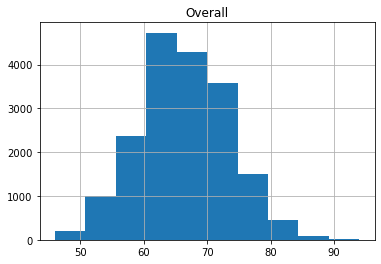

In [4]:
# view the distribution of overall score
fifa.select('Overall').toPandas().hist()

In [6]:
# collect results locally
ovr = fifa.select('Overall').toPandas()
top = ovr.quantile(0.975).values[0]
results = fifa.select('Name', 'Nationality', 'Age', 'Club', 'Overall').where(col('Overall') >= top).orderBy(col('Overall').desc())\
.collect()

# talk
print('%d players rated over %d'%(len(results), top))
print(results[0])

555 players rated over 80
Row(Name='L. Messi', Nationality='Argentina', Age=31, Club='FC Barcelona', Overall=94)


In [ ]:
sc.stop()